In [1]:
# general purpose data manipulation and analysis
import numpy as np
import scipy.spatial as spatial

# packages for working with raster datasets
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling

import xarray # allows us to work with raster data as arrays

# packages for working with geospatial data
import geopandas as gpd
import pandas as pd
!pip install pycrs
import pycrs

from shapely.geometry import box

# import packages for viewing the data
import matplotlib.pyplot as pyplot


In [2]:
#define paths
import os
CURDIR = os.path.dirname(os.path.realpath("__file__"))

In [3]:
# matplotlib functionality
%matplotlib inline
# %matplotlib notebook

## Canopy height models

We will use an existing raster of a canopy height model (CHM) to clip our snow depth map. This CHM is an area investigated by [Mazzotti et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR024898). You can also access the data [here](https://www.envidat.ch/#/metadata/als-based-snow-depth).

In [4]:
# load the chm
#chmc = xarray.open_rasterio('/home/jovyan/snow-sinking/data/CHM_20160926GMc_700x700_EPSG32612.tif')
#chmb = xarray.open_rasterio('/home/jovyan/snow-sinking/data/CHM_20160926GMb_700x700_EPSG32612.tif')
chmw = xarray.open_rasterio('/home/jovyan/bigData/west_box_canopyht_vf.tif')
chme = xarray.open_rasterio('/home/jovyan/bigData/east_box_canopyht_vf.tif')


Don't forget that if the coordinate systems in your datasets don't match then you will need to transform one of them. You can change the coordinate systems using the links above. (Note, I've already transformed this dataset from EPSG 32613).

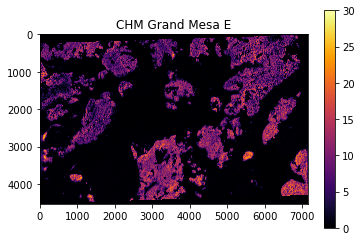

In [5]:
# plot the CHM, setting the maximum color value to the maximum canopy height in the dataset
fig3, ax3 = pyplot.subplots()
pos3 = ax3.imshow(chme.data[0,:,:], cmap='inferno', vmin=0, vmax = 30)#vmax=chmw.data.max())
ax3.set_title('CHM Grand Mesa E')
fig3.colorbar(pos3, ax=ax3)

In [6]:
np.max(chmw.data[0,:,:])

1089.31

### Canopy Density

**Method**

The [Canopy Fuel Estimator (CFE)](http://forsys.cfr.washington.edu/CFE/canopy_fuel_estimator.html) 

$$ \mathrm{CFE} = \frac{Number~returns~canopy~height~\geq~2~m}{Total~number~returns} $$

canopy density metric is defined as the proportion of first returns whose height is 2 meters or greater divided by the total number of first returns within some neighborhood (0.0 to 1.0). We computed the CFE on $0.5~m$ resolution lidar rasters, rather than LAS point cloud data to make use of the many befefits provided by `xarray`. We are searching a spatial domain with roughly $31.5$ million pixels. To speed up the computation we used kdtree searcher with a 5 m radius to find the nearest neighboring pixels of each coordinate.

to quantify the canopy density as measured by airborne lidar. We  to estimate the CFE

In [7]:
# Compute the CFE or Load a previously computed .tif
# Compute time is approx 2hr 30 minutes
isC = 0
isB = 0
isW = 1
isE = 0
if isC:
    cfe = chmc
    chm = chmc
elif isB:
    cfe = chmb
    chm = chmb
elif isW:
    cfe = chmw
    chm = chmw
elif isE:
    cfe = chme
    chm = chme
isKDTree = 0
# Allocate and Reshape Coordinates
y = cfe.y.values
x = cfe.x.values
leny = len(cfe.y.values)
lenx = len(cfe.x.values)
yyix = range(leny)
xxix = range(lenx)
xv,yv = np.meshgrid(x,y,sparse=False, indexing = 'xy')
xixv,yixv = np.meshgrid(xxix,yyix,sparse=False, indexing = 'xy')
xv = np.reshape(xv,-1)
yv = np.reshape(yv,-1)
xixv = np.reshape(xixv,-1)
yixv = np.reshape(yixv,-1)
coords = np.column_stack([xv,yv])
if isKDTree:
    mytree = spatial.cKDTree(coords)
    radius = 5
    # Loop through all coordinate points and compute the CFE
    for jj in range(len(yv)):
        point = [xv[jj],yv[jj]]
        ix = mytree.query_ball_point(point, radius,return_sorted=None, return_length=False)
        # Compute the CFE and Store it into our xarray
        yix,xix = np.unravel_index(ix,[leny,lenx])
        tmpix1 = np.argwhere(chm.data[0,yix,xix]>=2)
        tmpix2 = np.argwhere(chm.data[0,yix,xix]<2)
        # Must check if empty
        lentmpix1 = len(tmpix1)
        lentmpix2 = len(tmpix2)
        if not lentmpix1:
            cfe.data[0,yixv[jj],xixv[jj]] = 0
        else:    
            cfe.data[0,yixv[jj],xixv[jj]] = lentmpix1/(lentmpix1+lentmpix2)
        # This loop is if we want to do other stats with the searched data
            #bin = []
            #for kk in range(len(tmp)):
            #    tmpix1 = tmpix1[kk][0]
            #    tmpix2 = tmpix1[kk][1]
            #    bin.append(chmb.data[0][tmpix1][tmpix2])
else: # Load .tif Imagery
    if isB:
        in_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMb_700x700_EPSG32612.tif"
    if isC:
        in_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMc_700x700_EPSG32612.tif"
    if isW:
        in_tif = "/home/jovyan/bigData/west_box_cfe_5m.tif"
    if isE:
        in_tif = "/home/jovyan/bigData/east_box_cfe_5m.tif"
    cfe= xarray.open_rasterio(in_tif)

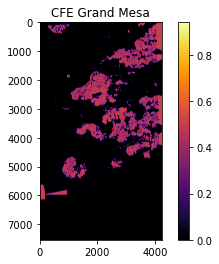

In [8]:
# plot the CFE, setting the maximum color value to the maximum canopy height in the dataset
fig3, ax3 = pyplot.subplots()
pos3 = ax3.imshow(cfe.data[0,:,:], cmap='inferno', vmin=0, vmax = cfe.data.max())
ax3.set_title('CFE Grand Mesa')
fig3.colorbar(pos3, ax=ax3)

In [9]:
if isKDTree:
    epsg_code = int(cfe.crs[11:])
    out_meta= ({"driver": "GTiff","dtype": "float32", 'nodata': -3.4028230607370965e+38, "width": cfe.shape[2],"height": cfe.shape[1],"count": 1, "transform": cfe.transform,"crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

In [10]:
if isB:
    out_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMb_700x700_EPSG32612.tif"
if isC:
    out_tif = "/home/jovyan/snow-sinking/data/CFE_20160926GMc_700x700_EPSG32612.tif"
if isW:
    out_tif = "/home/jovyan/snow-sinking/data/west_box_cfe_5m.tif"
if isE:
    out_tif = "/home/jovyan/snow-sinking/data/east_box_cfe_5m.tif"
    
isWrite = 0    
if isWrite:
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(cfe.data)

In [11]:
CFE = xarray.open_rasterio(out_tif)
CFE.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.327e+06 4.327e+06 4.327e+06 ... 4.323e+06 4.323e+06
  * x        (x) float64 7.417e+05 7.417e+05 7.417e+05 ... 7.438e+05 7.438e+05

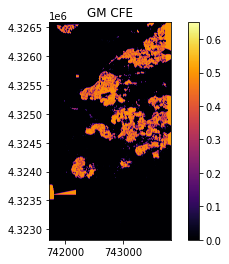

In [16]:
# plot the new SD map 
fig4, ax4 = pyplot.subplots()
pos4 = ax4.imshow(CFE.data[0,:,:], extent = [np.min(x),np.max(x),np.min(y),np.max(y)], cmap='inferno', vmin=0, vmax = 0.65)#vmax=np.max(CFE.data))
ax4.set_title('GM CFE')
fig4.colorbar(pos4, ax=ax4)

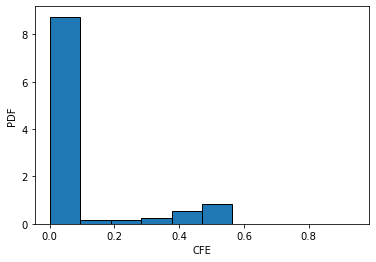

In [13]:
# Plot a Histogram of the CFE
pyplot.figure(1)
pyplot.hist(np.reshape(CFE.data[0],-1), density=True, bins= 10, edgecolor='black')  # density=False would make counts
pyplot.ylabel('PDF')
pyplot.xlabel('CFE');

In [14]:
np.max(np.reshape(cfe.data[0],-1))

0.9408284

Now that we have computed the CFE in the Lidar Domain, let's grab the canopy cover at our snowpits

In [15]:
if isE:
    in_csv ='/home/jovyan/snow-sinking/data/east_box.csv'
    out_csv ='/home/jovyan/snow-sinking/data/east_box_CFE.csv'
if isW:
    in_csv ='/home/jovyan/snow-sinking/data/west_box.csv'
    out_csv ='/home/jovyan/snow-sinking/data/west_box_CFE.csv'
    
sites = pd.read_csv(in_csv)
sites.head()
siteCoords = np.column_stack([sites.Easting__m_,sites.Northing__m_])
cfev = np.reshape(cfe.data[0],-1)
siteCFE = []
for ii in range(len(siteCoords)):
    dist = np.sqrt((siteCoords[ii,0]-xv)**2+(siteCoords[ii,1]-yv)**2)
    tmpix = np.argmin(dist)
    siteCFE.append(cfev[tmpix])
print(siteCFE)    
sites['CFE'] = siteCFE
sites.head()
sites.to_csv(out_csv)

[0.50157726, 0.0, 0.44479495, 0.50157726, 0.0, 0.0, 0.0, 0.02208202, 0.0, 0.0, 0.0, 0.0, 0.0]
